# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road**

## Import Packages

In [1]:
from __future__ import print_function
from pprint import pprint

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

import math

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Lane Detection Pipeline

### Helper Functions

In [2]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

### My Helper Functions

In [3]:
def intersection(line0, line1):
    """Find the point where two lines intersect
    
    Parameters
    ----------
    line0 : numpy.ndarray
        two points that define a line -- ``[[x0, y0, x1, y1]]``
    line1 : numpy.ndarray
        two points that define a line (same as ``line0``)
        
    Returns
    -------
    numpy.ndarray
        the point where ``line0`` and ``line1`` intersect -- ``[x, y]``
    
    """
    # \Delta x and \Delta y
    dx0 = line0[0][2] - line0[0][0]
    dy0 = line0[0][3] - line0[0][1]
    dx1 = line1[0][2] - line1[0][0]
    dy1 = line1[0][3] - line1[0][1]
    
    # A [x, y]^T = b
    A = np.array([[dy0, -dx0], [dy1, -dx1]])
    b = np.array([line0[0][0]*dy0 - line0[0][1]*dx0, line1[0][0]*dy1 - line1[0][1]*dx1])
    
    return np.round(np.linalg.solve(A, b))#.astype(np.uint16)


def find_x_given_y(line, y):
    """Given a line, solve for x when y is specified
    
    Parameters
    ----------
    line : numpy.ndarray
        two points that define a line -- ``[[x0, y0, x1, y1]]``
    y : float
        we want to find x such that (x, y) is on the line
        
    Returns
    -------
    numpy.ndarray
        ``[x, y]``, where x is such that (x, y) is on the line
    
    """
    dx = line[0][2] - line[0][0]
    dy = line[0][3] - line[0][1]
    
    return np.round(np.array([line[0][0] + (y - line[0][1])*dx/dy, y]))#.astype(np.uint16)


def intersection_or_ymax(line0, line1, y_const):
    """Given two lines, return whichever points are lower: their intersection with each other
    or their intersection with the line y=y_const
    
    Parameters
    ----------
    line0 : numpy.ndarray
        two points that define a line -- ``[[x0, y0, x1, y1]]``
    line1 : numpy.ndarray
        two points that define a line (same as ``line0``)
    y_const : float
        we will find the intersections of ``line0`` and ``line1`` with the line y=y_const
        
    Returns
    -------
    numpy.ndarray
        the point ``[x, y]`` where ``line0`` intersects ``line1`` OR where ``line0`` intersects y=y_const
    numpy.ndarray
        same as xy0, except for ``line1``
    
    """
    # point where the lines intersect each other
    xy = intersection(line0, line1)
    
    if xy[1] > y_const:
        return xy, xy
    else:
        return find_x_given_y(line0, y_const), find_x_given_y(line1, y_const)
    
    
def extend_to_bottom_top(line, y_bottom, y_top):
    """Extend ``line`` to the bottom and top of the masked image
    
    Parameters
    ----------
    line : numpy.ndarray
        two points that define a line -- ``[[x0, y0, x1, y1]]``
    y_bottom : float
        we will find the intersection of ``line`` with the line y=y_bottom
    y_top : float
        we will find the intersection of ``line`` with the line y=y_top
        
    Returns
    -------
    numpy.ndarray
        two points that define a line -- ``[[x0, y0, x1, y1]]``, where ``y0 = y_bottom``
        and ``y1 = y_top``
        
    """
    # find the points on the bottom and top
    xy_bottom = find_x_given_y(line, y_bottom)
    xy_top = find_x_given_y(line, y_top)
    
    return np.array([[xy_bottom[0], xy_bottom[1], xy_top[0], xy_top[1]]])


def extend_to_bottom(line, y_bottom):
    """Extend ``line`` to the bottom of the masked image
    
    Parameters
    ----------
    line : numpy.ndarray
        two points that define a line -- ``[[x0, y0, x1, y1]]``
    y_bottom : float
        we will find the intersection of ``line`` with the line y=y_bottom
        
    Returns
    -------
    numpy.ndarray
        two points that define a line -- ``[[x0, y0, x1, y1]]``, where ``y0 = y_bottom``
        
    """
    # find the points on the bottom and top
    xy_bottom = find_x_given_y(line, y_bottom)
    
    if line[0][1] > line[0][3]:
        return np.array([[xy_bottom[0], xy_bottom[1], line[0][2], line[0][3]]])
    else:
        return np.array([[xy_bottom[0], xy_bottom[1], line[0][0], line[0][1]]])
    
    
def get_slope(line):
    """Get the slope of the line
    
    Parameters
    ----------
    line : numpy.ndarray
        two points that define a line -- ``[[x0, y0, x1, y1]]``
        
    Returns
    -------
    float
        the slope of the line
        
    """
    if np.abs(float(line[0][2]) - float(line[0][0])) < 1e-6:
        return 1e6
    else:
        return (float(line[0][3]) - float(line[0][1])) / (float(line[0][2]) - float(line[0][0]))

### My `process_image()` Function

In [4]:
def process_image(image):
    """Draw the lane lines on an image
    
    Parameters
    ----------
    image : 
        the input image (RGB)
        
    Returns
    -------
    lines_edges : 
        the input image with lane lines drawn on (RGB)
        
    """    
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # get the image dimensions
    rows, cols = gray.shape
    
    ### STEP 1: apply Gaussian blur
    kernel_size = (5, 5)
    blur_gray = cv2.GaussianBlur(gray, kernel_size, 0)
    
    ### STEP 2: Canny edge detection
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    ### STEP 3: apply a mask to the image
    # parameters for the image mask and for filtering lines
    left = 0.12*cols
    right = 0.94*cols
    top = 0.55*rows
    top_width = 0.05*cols
    
    # parameters for filtering lines
    left_min = left
    left_max = 0.2*cols
    right_min = 0.86*cols
    right_max = right
    
    # a mask to be applied to the image
    top_left = (left + right - top_width)/2
    top_right = (left + right + top_width)/2
    vertices = np.array([[(left, rows), (top_left, top), (top_right, top), (right, rows)]],
                        dtype=np.int32)
    
    masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 200 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments  

    # initialize ``good_lines`` for the purpose of the while loop
    good_lines = []
    
    # adjust Hough transform parameters until we only get two lines
    while len(good_lines) != 2 and threshold > 0:
        ### STEP 4: apply the Hough Transform on the ``masked_edges`` image
        lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                    min_line_length, max_line_gap)

        ### STEP 5: process and filter the lines found by the Hough transform
        # sort the lines by their length
        lines = sorted(lines, key=lambda x: np.linalg.norm(x[2:] - x[:2]), reverse=True)
        
        # extend the lines to the bottom and top of the masked image
        lines = [extend_to_bottom_top(line, rows, top) for line in lines]

        # filter out lines based on their x-coordinates at the bottom and top of the masked image
        lines = [line for line in lines
                 if ((left_min <= line[0][0] <= left_max or right_min <= line[0][0] <= right_max) and
                     0.4*cols <= line[0][2] <= 0.7*cols)]

        # if we have more than 1 line, try to choose two lines
        if len(lines) > 1:
            # the first line is the longest line ==> calculate its slope
            m0 = get_slope(lines[0])

            # the second line is the longest line with opposite slope of the first line
            for line in lines:
                m1 = get_slope(line)
                if np.sign(m1) != np.sign(m0):
                    # remove "bad" entries in ``lines``
                    good_lines = [lines[0], line]

                    # get the top endpoints of the lines
                    xy0, xy1 = intersection_or_ymax(good_lines[0], good_lines[1], top)            
                    good_lines[0][0][2:] = xy0
                    good_lines[1][0][2:] = xy1
                    break
        
        # if we didn't find two good lines, then cut the Hough parameters in half and repeat
        threshold /= 2
        min_line_length /= 2
        max_line_gap /= 2
    
    # Iterate over the output "lines" and draw lines on a blank image
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    for line in good_lines:
        for x1,y1,x2,y2 in line.astype(np.uint16):
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))
    
    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0)

    return lines_edges

## Results

### Test Images

solidYellowCurve.jpg


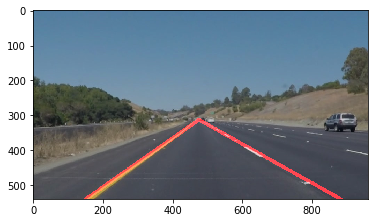

solidWhiteCurve.jpg


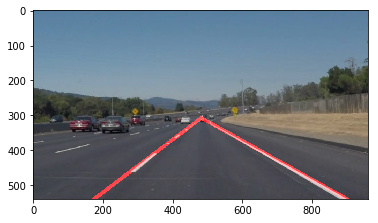

whiteCarLaneSwitch.jpg


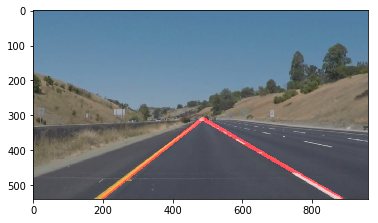

solidYellowLeft.jpg


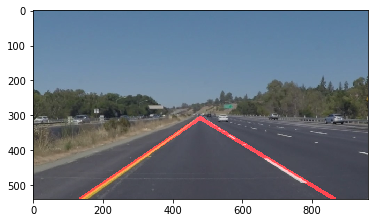

solidWhiteRight.jpg


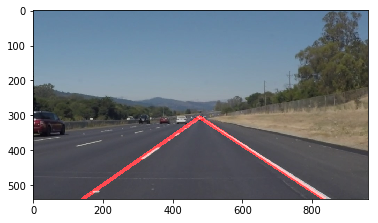

solidYellowCurve2.jpg


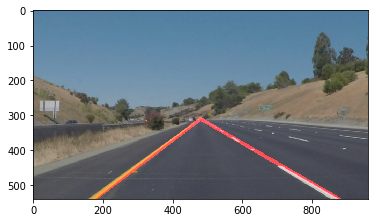

In [5]:
import os
test_image_dir = "../../Repos/CarND-LaneLines-P1/test_images/"
test_images = os.listdir(test_image_dir)

for img in test_images:
    print(img)
    image = mpimg.imread(test_image_dir + img)
    plt.imshow(process_image(image))
    plt.show()

### `solidWhiteRight.mp4`

In [6]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../../Repos/CarND-LaneLines-P1/test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 83.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.22 s, sys: 184 ms, total: 2.4 s
Wall time: 3.02 s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### `solidYellowLeft.mp4`

In [8]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('../../Repos/CarND-LaneLines-P1/test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:08<00:00, 84.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 6.72 s, sys: 508 ms, total: 7.23 s
Wall time: 8.38 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

### Challenge Video

In [10]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('../../Repos/CarND-LaneLines-P1/test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:05<00:00, 47.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 4.96 s, sys: 260 ms, total: 5.22 s
Wall time: 6.51 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))